#Generate data

In [157]:
import numpy as np
import random
import copy

#-----------------------#
#------ parameters -----#
#-----------------------#

MAP_DIM = 12
NUM_KERNALS = 2
KERNAL_SIZES = [1, 3, 5]

kernals = [[1], #1x1 kernal
            
          [[1, 2, 1], #3x3 kernal
          [2, 4, 2],
          [1, 2, 1]],

          [[1, 4, 7, 4, 1], #5x5 kernal
          [4, 16, 26, 16, 4],
          [7, 26, 41, 26, 7],
          [4, 16, 26, 16, 4],
          [1, 4, 7, 4, 1]]
          ]

# normalize the kernal
kernals[1] = np.array(kernals[1])*(1/16)
kernals[2] = np.array(kernals[2])*(1/273)

#----------------------------#
#------ Setup Functions -----#
#----------------------------#

# returns a matrix with the desired dimensions
def get_matrix(n):
    return np.zeros((n, n))

# returns a list of coordinates where Gaussian Centers
def get_gaussian_centers(kernal_sizes, allow_duplicates = True):
    
    gaussian_centers = []

    for num, size in enumerate(kernal_sizes):

      # determine bounds 
      # how far the kernal need to be from the edge
      # so the kernal does not extend out of bounds
      n = size
      lb = n                  # lower bound
      ub = MAP_DIM - n - 1     # upper bound


      # choose a point at random
      p = (random.randint(lb, ub), random.randint(lb, ub))


      # No Duplicates
      if allow_duplicates == False:
        while (p in set(gaussian_centers)):
          p = (random.randint(lb, ub), random.randint(lb, ub))

      gaussian_centers.append(p)

    return gaussian_centers

# returns the sum of all elements of a matrix
def validate_sum(mat):
  sum = 0
  for row in mat:
      for val in row:
         sum += val
    
  print('sum = ', sum)

# returns a new matrix with the probability distribution drawn in 
def populate_distribution(mat):
    
    # pick kernal sizes randomly
    kernal_sizes = []
    for i in range(0, NUM_KERNALS):
       kernal_sizes.append(random.randint(0, 2))

    # pick centers for each of the kernals
    kernal_centers = get_gaussian_centers(kernal_sizes)
    print(kernal_centers)


    # Draw the kernals into the map by adding each kernal to 0
    for i, size in enumerate(kernal_sizes):
      x = kernal_centers[i][1]
      y = kernal_centers[i][0]

      if size == 0:
         mat[y][x] += kernals[size][0]/NUM_KERNALS
      else:
        for ind1, row in enumerate(kernals[size]):
          for ind2, val in enumerate(row):
            mat[y-size+ind1][x-size+ind2] += val/NUM_KERNALS


    return mat


# choose a target from the 3d distribution
def define_a_target(mat):
    i = 0
    j = 0

    # pick a random number n between 0 and 1
    # traverse the graph summing cells unitl sum > n
    n = random.uniform(0, 1)
    sum = 0
    point = None
    for (index1, i) in enumerate(mat):
      for (index2, j) in  enumerate(i):
        sum+=j
        if (sum > n and point == None):
          point = (index1, index2)

    return point

def create_visual_aid(matrix, target):
  mat = copy.deepcopy(matrix)
  print("TARGET = ", target)
  for row in mat:
    row2 = []
    for item in row:
       row2.append("{:.2f}".format(item))
    print(row2)

def get_populated_map(MAP_DIM):
  mat = get_matrix(MAP_DIM)
  mat = populate_distribution(mat)
  validate_sum(mat)
  return mat


In [158]:
mat = get_populated_map(MAP_DIM)

target = define_a_target(mat)
va = create_visual_aid(mat, target)


[(9, 9), (4, 6)]
sum =  1.0
TARGET =  (4, 6)
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.50', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.03', '0.06', '0.03', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.06', '0.12', '

#Update probability distribution

In [159]:
#params
ed = 0.05   # missed detection
ef = 0.01   # false alarm


# takes in the probability distribution matrix and the current square as arguments
# returns updated matrix
def update_probability_distribution(mat, curr, verbose=0):

  # calculate bi
  bi = ed*mat[curr[0]][curr[1]]+(1-ef)*(1-mat[curr[0]][curr[1]])

  for (row, vec) in enumerate(mat):
    for (col, item) in enumerate(mat[row]):
      if item > 0:
        if curr[0] == row and curr[1] == col:
          mat[row][col] *= (ed/bi)
        else:
          mat[row][col] *= ((1 - ef)/bi)

  if verbose != 0:
    sum = np.sum(mat)
    if sum > 1.0001 or sum < 0.9999:
      print("sum was not 1, sum was: ", sum)
      print(mat)
    else:
      print("good job")
      print(mat)

  return mat



In [160]:
mat2 = update_probability_distribution(mat, (2, 8), 1)
print(mat2)

good job
[[0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.5     0.      0.
  0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.03125
  0.0625  0.03125 0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.0625
  0.125   0.0625  0.     ]
 [0.      0.      0.  

# Reward Policy

In [188]:
default_policy = {                      # Original policy 
'OOB_penalty': -10000,                   # Discourage going out of bounds
'revisit_penalty': -0.2,                # Discourage from revisiting the same square many times, between 0 and 1 because used as nn input
"revisit_penalty_multiplier": 1000,     # multiplier to calculate actual reward 
"prob_reward_multiplier": 4000,         # Multiplied by the probabiliy of the square to encourage visiting green squares   
"bb_reward": 0.3,                       # Encourage heading towards the bounding box, higher than the revisit penalty because you should take the shortest path back to the bounding box even if you've been there
"bb_penalty": -0.3,                      # Discourage moving away from the bounding box
"bb_policy_multiplier": 1000,
"win_reward": 10000,                    # Reward for winning
"speed_penalty": 20,                    # Reward less for taking longer 
"movement_penalty": -10,
}

policy2 = {                             # New policy, only penalize for going out of bounds 
'OOB_penalty': -10000,                  # Reward only for winning
"revisit_penalty_multiplier": 0,
'revisit_penalty': -0.2,                   # We thought maybe by only rewarding for winning and rewarding more for winning quickly
"prob_reward_multiplier": 100,          # The model would unlearn bad behaviors it learned from the old policy, and learn new better behaviors
"bb_reward": 0.3,                         # such as refusing to visit the target square if it was surrounded by red squares
"bb_penalty": -0.3,                        # we willy try fine tuning on this model
"bb_policy_multiplier": 0,
"win_reward": 10000,          
"speed_penalty": 50,
"movement_penalty": -10             
}

# Prepping For Graphs

In [197]:
game_results=[]
TTW = [] #time to win
TTWMA = []
total_games = 0

wins = 0
oob = 0
timeout = 0

history_wins = []
history_OOB = []
history_timeout = []


win_percentage = []
OOB_percentage = []
timeout_percentage = []

win_window_50 = []
oob_window_50 = []
timeout_window_50 = []

cumulative_reward = []
reward_window_50 = []

avg_TTW = 0

def reset_graphs(): #this isnt working

    game_results=[]
    TTW = [] #time to win
    TTWMA = []
    total_games = 0

    wins = 0
    oob = 0
    timeout = 0

    history_wins = []
    history_OOB = []
    history_timeout = []


    win_percentage = []
    OOB_percentage = []
    timeout_percentage = []

    win_window_50 = []
    oob_window_50 = []
    timeout_window_50 = []

    cumulative_reward = []
    reward_window_50 = []

    avg_TTW = 0

reset_graphs()

# Modified Snake Game

In [163]:
import pygame
import random
from enum import Enum
from collections import namedtuple
import numpy as np

pygame.init()
#font = pygame.font.Font('arial.ttf', 25)

class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

Point = namedtuple('Point', 'x, y')

# rgb colors
WHITE = (255, 255, 255)
BLUE1 = (0, 0, 255)
BLUE2 = (0, 100, 255)
BLACK = (0,0,0)
GOLD = (255, 215, 0)
RED = []
CYAN = (0, 255, 255)
MAGENTA = (255, 0, 255)

# Calculate 11 shades of red, higher intensity reds for higher penalties
num = 255
for x in range(1, 11):
   RED.append((num, 0, 0))
   num -= 25
RED.reverse()

# Calculate pixel Sizes 
BLOCK_SIZE = 25
BORDER_SIZE = 10
MINI_BLOCK_SIZE = BLOCK_SIZE - BORDER_SIZE
SCALER = 3
BLOCK_SIZE = BLOCK_SIZE*SCALER
BORDER_SIZE = BORDER_SIZE*SCALER/2
MINI_BLOCK_SIZE = MINI_BLOCK_SIZE*SCALER

# The speed at which the simulation runs
# High values such as 40 for training
# Low values such as 0.25 for inspecting values
SPEED = 40

# Size of the window
WIDTH = BLOCK_SIZE * MAP_DIM
HEIGHT = BLOCK_SIZE * MAP_DIM

ed = 0.05   # missed detection
ef = 0.01   # false alarm

class SnakeGameAI:

    def __init__(self, reward_policy=None, enable_visualization=True):
        self.reward_policy = None
        if reward_policy == None:
            self.reward_policy = default_policy
            print("reward policy was none")
            print(default_policy)
        else:
            print("reward policy exists")
            print(reward_policy)
            self.reward_policy = reward_policy
        self.w = WIDTH
        self.h = HEIGHT
        self.enable_visualization = enable_visualization
        # init display
        self.display = pygame.display.set_mode((self.w, self.h))
        pygame.display.set_caption('Drone')
        self.clock = pygame.time.Clock()
        self.reset()
        print(self.reward_policy)


    def reset(self):
        self.drone_map = (random.randint(0, MAP_DIM-1), random.randint(0, MAP_DIM-1))
        self.drone = Point(self.drone_map[0], self.drone_map[1])
        self.score = 0
        self.map = self._gen_map()
        self.target_map = define_a_target(self.map)
        self.bounding_box = self.get_bounding_box()
        self.bb_draw = self.get_bb_draw()
        self.visited_map = get_matrix(MAP_DIM)
        self.bb_policy_map = self.prepare_bb_policy_map()
        self.map_sum = np.add(self.map, self.visited_map)
        self._place_target()
        self.frame_iteration = 0
        self.cumulative_reward = 0
        self.bb_reward = [0, 0, 0, 0]
        self.prob_reward = [0, 0, 0, 0]
        self.revisit_penalty = [0, 0, 0, 0]
        #create_visual_aid(self.map, self.target_map)


    def _place_target(self):
        # choose a target from the 3d distribution
        i = 0
        j = 0

        # pick a random number n between 0 to 1
        # traverse the graph summing cells until sum > n
        n = random.uniform(0, 1)
        print(n)
        sum = 0
        point = None
        for (index1, i) in enumerate(self.map):
          for (index2, j) in  enumerate(i):
            sum += j
            if (sum > n and point == None):
              point = (index1, index2)

        self.target_map = point
        return
    
    def prepare_data_for_graphs(self):
        global oob
        global wins
        global timeout
        global total_games

        total_games+=1
        history_wins.append(wins)
        history_OOB.append(oob)
        history_timeout.append(timeout)

        OOB_percentage.append(oob/total_games)
        win_percentage.append(wins/total_games)
        timeout_percentage.append(timeout/total_games)

        cumulative_reward.append(self.cumulative_reward)
        if len(game_results) > 100:
            rew50 = game_results[-100:]
            avg = np.mean(np.array(rew50))
            reward_window_50.append(avg)
        else:
            avg = np.mean(np.array(cumulative_reward))
            reward_window_50.append(avg)
        
        if len(game_results) > 100:
            rec50 = game_results[-100:]
            num_wins = rec50.count(2)
            num_oob = rec50.count(1)
            num_timeout = rec50.count(3)
            win_window_50.append(num_wins/100)
            oob_window_50.append(num_oob/100)
            timeout_window_50.append(num_timeout/100)
        else: 
            leng = len(game_results)
            num_wins = game_results.count(2)
            num_oob = game_results.count(1)
            num_timeout = game_results.count(3)
            win_window_50.append(num_wins/leng)
            oob_window_50.append(num_oob/leng)
            timeout_window_50.append(num_timeout/leng)
        return
    
    def prepare_TTW_graph(self):
        TTW.append(self.frame_iteration)
        if len(TTW) >= 30:
            res = TTW[-30:]
            TTWMA.append(np.average(res))
        else:
            TTWMA.append(np.average(TTW))
        return    

    def play_step(self, action):
        self.frame_iteration += 1
        self.score += 1
        reward = self.reward_policy["movement_penalty"]
        game_over = False

        # prepare the bb policy mad for the turn
        # calculate rewards of adjacent spaces based on current state

        # 1. collect user input
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()

        # 2. move
        prev = self._move(action) # update the drone location
        self.visited_map[prev[0]][prev[1]] += self.reward_policy["revisit_penalty"]
        
        global oob
        global wins
        global timeout

        #3. check if out of bounds
        if self.is_collision():
            print("OOB")
            game_over = True
            reward = self.reward_policy["OOB_penalty"]
            game_results.append(1)
            oob += 1

            self.prepare_data_for_graphs()

            return reward, game_over, self.score


        # 4. check if target found
        if self.drone_map[0] == self.target_map[0] and self.drone_map[1] == self.target_map[1]:
            print("WIN")
            game_over = True
            reward = self.reward_policy["win_reward"] + self.map[self.drone_map[0]][self.drone_map[1]]*self.reward_policy["prob_reward_multiplier"]
            reward -= self.frame_iteration*self.reward_policy["speed_penalty"]
            game_results.append(2)
            wins += 1
            
            self.prepare_data_for_graphs()
            self.prepare_TTW_graph()

            return reward, game_over, self.score


        # 5. To prevent the agent from going in circles and never ending
        #    limit game to 300 moves
        if self.frame_iteration == 300:
            print("TO")
            game_over = True
            reward = self.reward_policy["movement_penalty"]
            game_results.append(3)
            timeout += 1

            self.prepare_data_for_graphs()
          
            return reward, game_over, self.score


        # 6. Check if stepping on tail
        if self.visited_map[self.drone_map[0]][self.drone_map[1]] < 0:
           print("revisited space")
           print("reward (revisited): ", self.visited_map[self.drone_map[0]][self.drone_map[1]]*self.reward_policy["revisit_penalty_multiplier"])
           reward += self.visited_map[self.drone_map[0]][self.drone_map[1]]*self.reward_policy["revisit_penalty_multiplier"]


        # 7. Reward for checking a high probability space
        reward += (self.map[self.drone_map[0]][self.drone_map[1]]*self.reward_policy["prob_reward_multiplier"])
        print("reward (green space): ", (self.map[self.drone_map[0]][self.drone_map[1]]*self.reward_policy["prob_reward_multiplier"]))
        
        # 8. Reward for moving within or towards the bounding box of the probability distribution
        #    Punish for Leaving, Moving away from, or traveling outside the bounding box
        #    Calculate rewards for next time
        reward += self.bb_policy_map[self.drone_map[0]][self.drone_map[1]]*self.reward_policy["bb_policy_multiplier"]
        print("reward (bb policy): ", ( self.bb_policy_map[self.drone_map[0]][self.drone_map[1]]*self.reward_policy["bb_policy_multiplier"]))
        print('reward (Total) = ', reward)

        # Keep track of cumulative reward per game
        self.cumulative_reward += reward

        # 9. update game state
        if self.map[self.drone_map[0]][self.drone_map[1]] > 0:
            self._update_probability_dist()
        self.map_sum = np.add(self.map, self.visited_map)
        self.bb_policy_map = self.prepare_bb_policy_map()
        self.update_revisit_penalty()
        self.update_probability_reward()


        # 10. update the  
        if self.enable_visualization == True:
            self._update_ui()
            self.clock.tick(SPEED)

        # 11. return game over and score
        return reward, game_over, self.score

    def update_probability_reward(self):
        self.prob_reward = [0, 0, 0, 0]
        if self.drone_map[0] != MAP_DIM -1:
            if self.map[self.drone_map[0]+1][self.drone_map[1]] > 0:
                self.prob_reward[0] = 1
        if self.drone_map[0] != 0:
            if self.map[self.drone_map[0]-1][self.drone_map[1]] > 0:
                self.prob_reward[1] = 1
        if self.drone_map[1] != MAP_DIM -1:
            if self.map[self.drone_map[0]][self.drone_map[1]+1] > 0:
                self.prob_reward[2] = 1
        if self.drone_map[1] != 0:
            if self.map[self.drone_map[0]][self.drone_map[1]-1] > 0:
                self.prob_reward[3] = 1
    
    def update_revisit_penalty(self):
        self.revisit_penalty = [0, 0, 0, 0]
        if self.drone_map[0] != MAP_DIM - 1:
            if self.visited_map[self.drone_map[0]+1][self.drone_map[1]] < 0:
                self.revisit_penalty[0] = 1
        if self.drone_map[0] != 0:
            if self.visited_map[self.drone_map[0]-1][self.drone_map[1]] < 0:
                self.revisit_penalty[1] = 1
        if self.drone_map[1] != MAP_DIM -1:
            if self.visited_map[self.drone_map[0]][self.drone_map[1]+1] < 0:
                self.revisit_penalty[2] = 1
        if self.drone_map[1] != 0:
            if self.visited_map[self.drone_map[0]][self.drone_map[1]-1] < 0:
                self.revisit_penalty[3] = 1

    def prepare_bb_policy_map(self):
        #reset the map
        bb_policy_map = get_matrix(MAP_DIM)

        #set initial reward for going in each direction
        reward_down = 0
        reward_up = 0
        reward_left = 0
        reward_right = 0

        # get the case
        # the drone can be in 1 of 9 positions with respect to the bounding box
        # above, inside vertically, below represented by 0, 1, 2 respectively
        # right, inside horizontally, left below represented by 0, 1, 2 respectively

        #our case variables, the vertical and horizontal representations of the case
        v = None
        h = None

        # set the vertical conponent of the case
        if self.drone_map[0] < self.bounding_box["tr"][0]:
            v = 0
        elif self.drone_map[0] > self.bounding_box["br"][0]:
            v = 2
        elif self.drone_map[0] >= self.bounding_box["tr"][0] and self.drone_map[0] <= self.bounding_box["br"][0]:
            v = 1
        else:
            print("THERE WAS A PROBLEM CALCULATING THE VERTICAL CASE")

        # set the horizontal conponent of the case
        if self.drone_map[1] < self.bounding_box["tl"][1]:
            h = 0
        elif self.drone_map[1] > self.bounding_box["br"][1]:
            h = 2
        elif self.drone_map[1] >= self.bounding_box["tl"][1] and self.drone_map[1] <= self.bounding_box["br"][1]:
            h = 1
        else:
            print("THERE WAS A PROBLEM CALCULATING THE HORIZONTAL CASE")


        #Set the potential rewards for each case
        if v == 0 and h == 0:
            reward_down = self.reward_policy["bb_reward"]
            reward_up = self.reward_policy["bb_penalty"]
            reward_left = self.reward_policy["bb_penalty"]
            reward_right = self.reward_policy["bb_reward"]

        if v == 0 and h == 1:
            reward_down = self.reward_policy["bb_reward"]
            reward_up = self.reward_policy["bb_penalty"]
            reward_left = self.reward_policy["bb_penalty"]
            reward_right = self.reward_policy["bb_penalty"]

        if v == 0 and h == 2:
            reward_down = self.reward_policy["bb_reward"]
            reward_up = self.reward_policy["bb_penalty"]
            reward_left = self.reward_policy["bb_reward"]
            reward_right = self.reward_policy["bb_penalty"]

        if v == 1 and h == 0:
            reward_down = self.reward_policy["bb_penalty"]
            reward_up = self.reward_policy["bb_penalty"]
            reward_left = self.reward_policy["bb_penalty"]
            reward_right = self.reward_policy["bb_reward"]

        if v == 1 and h == 1:  # we only want to penalize for leaving the bounding box in this case
            if  self.drone_map[0] == self.bounding_box["br"][0]:
                reward_down = self.reward_policy["bb_penalty"]
            if  self.drone_map[0] == self.bounding_box["tl"][0]:
                reward_up = self.reward_policy["bb_penalty"]
            if  self.drone_map[1] == self.bounding_box["tl"][1]:
                reward_left = self.reward_policy["bb_penalty"]
            if  self.drone_map[1] == self.bounding_box["br"][1]:
                reward_right = self.reward_policy["bb_penalty"]

        if v == 1 and h == 2:
            reward_down = self.reward_policy["bb_penalty"]
            reward_up = self.reward_policy["bb_penalty"]
            reward_left = self.reward_policy["bb_reward"]
            reward_right = self.reward_policy["bb_penalty"]

        if v == 2 and h == 0:
            reward_down = self.reward_policy["bb_penalty"]
            reward_up = self.reward_policy["bb_reward"]
            reward_left = self.reward_policy["bb_penalty"]
            reward_right = self.reward_policy["bb_reward"]

        if v == 2 and h == 1:
            reward_down = self.reward_policy["bb_penalty"]
            reward_up = self.reward_policy["bb_reward"]
            reward_left = self.reward_policy["bb_penalty"]
            reward_right = self.reward_policy["bb_penalty"]

        if v == 2 and h == 2:
            reward_down = self.reward_policy["bb_penalty"]
            reward_up = self.reward_policy["bb_reward"]
            reward_left = self.reward_policy["bb_reward"]
            reward_right = self.reward_policy["bb_penalty"]
            
        # if drone isnt on the bottom edge
        # apply the reward/penalty for going down 
        if self.drone_map[0] != MAP_DIM - 1:
            bb_policy_map[self.drone_map[0]+1][self.drone_map[1]] = reward_down

        # if drone isnt on the top edge
        # apply the reward/penalty for going up 
        if self.drone_map[0] != 0:
            bb_policy_map[self.drone_map[0]-1][self.drone_map[1]] = reward_up

        # if drone isnt on the right edge
        # apply the reward/penalty for going right 
        if self.drone_map[1] != MAP_DIM - 1:
            bb_policy_map[self.drone_map[0]][self.drone_map[1]+1] = reward_right

        # if drone isnt on the left edge
        # apply the reward/penalty for going left 
        if self.drone_map[1] != 0:
            bb_policy_map[self.drone_map[0]][self.drone_map[1]-1] = reward_left
        
        # create_visual_aid(self.map, self.target_map)
        # print(self.bb_policy_map)

        self.bb_reward=[reward_up*5, reward_down*5, reward_left*5, reward_right*5]

        return bb_policy_map

    # Check if the drone went out of bounds
    def is_collision(self):
        if self.drone_map[1] > MAP_DIM - 1 or self.drone_map[1] < 0 or self.drone_map[0] > MAP_DIM - 1 or self.drone_map[0] < 0:
            return True
        return False

    # Draw the current state of the game
    def _update_ui(self):

        # Fill the background with black
        self.display.fill(BLACK)

        # Draw all non zero probability spaces with Green
        for (row, vec) in enumerate(self.map):
          for (col, item) in enumerate(self.map[row]):
            if self.map[row][col] > 0:
                GREEN = int(round((item*230+25)))
                if GREEN > 255 or GREEN < 0:
                    print('GREEN = ', GREEN)
                GREEN = (0, GREEN, 0)
                pygame.draw.rect(self.display, GREEN, pygame.Rect(col*BLOCK_SIZE, row*BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE))


        # Draw the target in gold
        pygame.draw.rect(self.display, GOLD, pygame.Rect(self.target_map[1]*BLOCK_SIZE+BORDER_SIZE, self.target_map[0]*BLOCK_SIZE+BORDER_SIZE, MINI_BLOCK_SIZE, MINI_BLOCK_SIZE))


        # Draw the revisit penalty in red (Brighter red for higher penalty)
        for indx1, row in enumerate(self.visited_map):
          for indx2, val in enumerate(row):
            if val < 0:
                shade = int(round(val*-10))-1
                print("shade, val = ",shade, val)
                if shade < 0:
                  shade = 0
                if shade >= 10:
                   shade = 9      
                pygame.draw.rect(self.display, RED[shade], pygame.Rect(indx2*BLOCK_SIZE, indx1*BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE))

        # Draw the bounding box of the probability distribution
        pygame.draw.lines(self.display, (255, 255, 255), True, (self.bb_draw["tl"], self.bb_draw["tr"], self.bb_draw["br"], self.bb_draw["bl"]), 1)

        #draw the bounding box policy rewards
        for indx1, row in enumerate(self.bb_policy_map):
          for indx2, val in enumerate(row):
            if val > 0:
                pygame.draw.rect(self.display, CYAN, pygame.Rect(indx2*BLOCK_SIZE+BORDER_SIZE, indx1*BLOCK_SIZE+BORDER_SIZE, MINI_BLOCK_SIZE, MINI_BLOCK_SIZE)) 
            if val < 0:
               pygame.draw.rect(self.display, MAGENTA, pygame.Rect(indx2*BLOCK_SIZE+BORDER_SIZE, indx1*BLOCK_SIZE+BORDER_SIZE, MINI_BLOCK_SIZE, MINI_BLOCK_SIZE)) 

        # Draw reference block at 0,0
        # pygame.draw.rect(self.display, (255, 121, 0), pygame.Rect(BORDER_SIZE, BORDER_SIZE, MINI_BLOCK_SIZE, MINI_BLOCK_SIZE))

        # Draw the Drone in Blue
        pygame.draw.rect(self.display, BLUE2, pygame.Rect(self.drone_map[1]*BLOCK_SIZE+BORDER_SIZE, self.drone_map[0]*BLOCK_SIZE+BORDER_SIZE, MINI_BLOCK_SIZE, MINI_BLOCK_SIZE))

        pygame.display.flip()


    # Apply the Bayesian rule after visiting a square
    def _update_probability_dist(self):
        curr = self.drone_map
        bi = ed*self.map[curr[0]][curr[1]]+(1-ef)*(1-self.map[curr[0]][curr[1]])

        for (row, vec) in enumerate(self.map):
          for (col, item) in enumerate(self.map[row]):
            if item > 0:
              if curr[0] == row and curr[1] == col:
                self.map[row][col] *= (ed/bi)
              else:
                self.map[row][col] *= ((1 - ef)/bi)

    # Move the Drone based on the action taken
    def _move(self, action):

        prev = self.drone_map

        # transform coordinates
        col = self.drone_map[1]
        row = self.drone_map[0]

        print(self.drone_map)

        # move the points
        if np.array_equal(action, [1, 0, 0, 0]):
            col += 1
            print("right")
        elif np.array_equal(action, [0, 1, 0, 0]):
            col -= 1
            print("left")
        elif np.array_equal(action, [0, 0, 1, 0]):
            row += 1
            print("down")
        elif np.array_equal(action, [0, 0, 0, 1]):
            row -= 1
            print("up")


        # Update the coordinataes
        self.drone_map = (row, col)

        return prev

    # Generate a map
    def _gen_map(self):
        mat = get_matrix(MAP_DIM)
        mat = populate_distribution(mat)
        return mat
    
    # Get the bounding box of the probability distribution
    def get_bounding_box(self):
        xmax = None
        xmin = None
        ymax = None
        ymin = None
        for index, row in enumerate(self.map):
            if sum(row) > 0:
                ymax = index
                if ymin == None:
                    ymin = index
        for index, column in enumerate(zip(*self.map)):
            if sum(column) > 0:
                xmax = index
                if xmin == None:
                    xmin = index

        print(xmax, xmin, ymax, ymin)            

        return { 'tl': [ymin,xmin], 'tr':[ymin, xmax], 'bl': [ymax, xmin], 'br': [ymax, xmax]}
    
    # convert the bounding box format into one that makes it easier to draw with pygame
    def get_bb_draw(self):
        bb_draw = copy.deepcopy(self.bounding_box)
        bb_draw["tl"][0] = self.bounding_box["tl"][1]*BLOCK_SIZE
        bb_draw["tl"][1] = self.bounding_box["tl"][0]*BLOCK_SIZE
        bb_draw["tr"][0] = self.bounding_box["tr"][1]*BLOCK_SIZE+BLOCK_SIZE
        bb_draw["tr"][1] = self.bounding_box["tr"][0]*BLOCK_SIZE
        bb_draw["bl"][0] = self.bounding_box["bl"][1]*BLOCK_SIZE
        bb_draw["bl"][1] = self.bounding_box["bl"][0]*BLOCK_SIZE+BLOCK_SIZE
        bb_draw["br"][0] = self.bounding_box["br"][1]*BLOCK_SIZE+BLOCK_SIZE
        bb_draw["br"][1] = self.bounding_box["br"][0]*BLOCK_SIZE+BLOCK_SIZE
        
        return bb_draw
       


# PyTorch model and Trainer

In [164]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

class Linear_QNet(nn.Module):
    def __init__(self, input_size, hidden_size1,  output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size1)
        self.linear3 = nn.Linear(hidden_size1, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)


class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)
        # (n, x)

        if len(state.shape) == 1:
            # (1, x)
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        # 1: predicted Q values with current state
        pred = self.model(state)

        targ = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

            targ[idx][torch.argmax(action[idx]).item()] = Q_new

        # 2: Q_new = r + y * max(next_predicted Q value) -> only do this if not done
        # pred.clone()
        # preds[argmax(action)] = Q_new
        self.optimizer.zero_grad()
        loss = self.criterion(targ, pred)
        loss.backward()

        self.optimizer.step()

# Helper Functions

In [165]:
import matplotlib.pyplot as plt
from IPython import display

def tuple2onehot(tuple):
    onehot_x = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    onehot_y = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    if tuple[1] >= 0 and tuple[1] < 12:
        onehot_x[tuple[1]] = 1
    if tuple[0] >= 0 and tuple[0] < 12:
        onehot_y[tuple[0]] = 1
    return onehot_x, onehot_y

def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)    
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

In [166]:
def get_probability_up(mat, loc):
    prob=0
    if(loc[0] == 0):
        return 0
    else:
        idx = 0
        while idx < loc[0]:
            row = mat[idx]
            prob = prob + sum(row)
            idx += 1
    return prob

def get_probability_down(mat, loc):
    prob=0
    if(loc[0] == 11):
        return 0
    else:
        idx = 11
        while idx > loc[0]:
            row = mat[idx]
            prob = prob + sum(row)
            idx -= 1
    return prob

# MAP_DIM = 12
# mat = get_populated_map(MAP_DIM)
# loc = (4, 4)
# for i in range(0, 3):
#     mat = [list(reversed(col)) for col in zip(*mat)]


# va = create_visual_aid(mat, loc)
# print(get_probability_up(mat, loc))
# print(get_probability_down(mat, loc))
# rotated = [list(reversed(col)) for col in zip(*mat)]
# loc = (loc[1], 9-loc[0])
# print(get_probability_down(rotated, loc))
# print(get_probability_up(rotated, loc))

# Agent

In [167]:
import torch
import random
import numpy as np
from collections import deque
import copy

MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.1

MAP_SIZE = MAP_DIM*MAP_DIM
LOCATION_SIZE = MAP_DIM*2
REWARD_PRED_SIZE = 12
OTHER_SIZE = 8
input_dim = MAP_SIZE + LOCATION_SIZE + REWARD_PRED_SIZE+ OTHER_SIZE  # map + position  + probability_mat + danger_mat
hidden_dim1 = 1024
# hidden_dim2 = 2048  #2 layer model didnt seem to work that well
output_dim = 4 # up, down, right, left

class Agent:

    def __init__(self, model=None):
        self.n_games = 0
        self.epsilon = 0 # randomness
        self.gamma = 0.99 # discount rate
        self.memory = deque(maxlen = MAX_MEMORY) # popleft()
        if model == None:
            self.model = Linear_QNet(input_dim, hidden_dim1, output_dim)
        else:
            self.model = model
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

    


    def get_state(self, game):
        
        # Change the formatting of the drone location 
        drone = game.drone_map
        drone_x, drone_y = tuple2onehot(drone)

        # Add up the map types
        map = normalize(np.array(game.map).flatten(), 0, 1)
        map = np.add(map, np.array(game.visited_map).flatten())
        map = np.add(map, np.array(game.bb_policy_map).flatten())

        # Add the location to the state
        state = np.append(np.array(map).flatten(), drone_x)
        state = np.append(np.array(state).flatten(), drone_y)
        
        # Add the total probability in each direction to the state
        mat = copy.deepcopy(game.map)
        loc = game.drone_map

        prob_mat = [0, 0, 0, 0]
        prob_mat[0] = get_probability_up(mat, loc)
        prob_mat[1] = get_probability_down(mat, loc)
        rotated = [list(reversed(col)) for col in zip(*mat)]
        loc = (loc[1], 11-loc[0])
        prob_mat[2] = get_probability_down(rotated, loc)
        prob_mat[3] = get_probability_up(rotated, loc)
        state = np.append(np.array(state).flatten(), prob_mat)
        
        # Is 1 if on the border, 0 otherwise
        danger_mat = [0, 0, 0, 0]
        danger_mat[0] = drone_x[0]
        danger_mat[1] = drone_x[11]
        danger_mat[2] = drone_y[0]
        danger_mat[3] = drone_y[11]
        state = np.append(np.array(state).flatten(), danger_mat)

        # Add probability of space in each direction 
        # Add bb reward to state
        # Add revisit penalty to state
        state = np.append(np.array(state).flatten(), game.revisit_penalty)
        state = np.append(np.array(state).flatten(), game.bb_reward)
        state = np.append(np.array(state).flatten(), game.prob_reward)


        return np.array(state)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)
        # for state, action, reward, nexrt_state, done in mini_sample:
        #    self.trainer.train_step(state, action, reward, next_state, done)

    def train_short_memory(self, state, action, reward, next_state, done):
        #print(type(state), type(action), type(reward), type(next_state) )
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 66 - (self.n_games/10)
        final_move = [0, 0, 0, 0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 3)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move

# Prepare to Train

In [168]:
# Load a model if you have one
model = torch.load('C:/users/Dave/Downloads/ECE601model.pth')

In [169]:
if model != None:
    agent = Agent(model)
else:
    agent =  Agent()


In [185]:
def train(num_games, agent, reward_policy=None, enable_visualization=True):
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    print(reward_policy)
    game = SnakeGameAI(reward_policy=reward_policy, enable_visualization=enable_visualization)
    print(game.reward_policy)
    agent.n_games = 0
    while agent.n_games < num_games:
        # get old state
        state_old = agent.get_state(game)

        # get move
        final_move = agent.get_action(state_old)

        # perform move and get new state
        reward, done, score = game.play_step(final_move)
        state_new = agent.get_state(game)

        # train short memory
        agent.train_short_memory(state_old, final_move, reward, state_new, done)

        # remember
        agent.remember(state_old, final_move, reward, state_new, done)

        if done:
            # train long memory, plot result
            game.reset()
            agent.n_games += 1
            agent.train_long_memory()

            if score > record:
                record = score
                agent.model.save()

            print('Game', agent.n_games, 'Score', score, 'Record:', record)

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            fig, ax = plt.subplots(2, 2)
            display.clear_output(wait=True)
            display.display(plt.gcf())
            ax[0, 0].plot(history_wins, label='wins')
            ax[0, 0].plot(history_OOB, label='oob')
            ax[0, 0].plot(history_timeout, label='timeout')
            ax[0, 1].plot(cumulative_reward, label='wins')
            ax[0, 1].plot(reward_window_50, label='oob')
            ax[1, 0].plot(TTW, label='wins')
            ax[1, 0].plot(TTWMA, label='oob')
            ax[1, 1].plot(win_window_50, label='wins')
            ax[1, 1].plot(oob_window_50, label='oob')
            ax[1, 1].plot(timeout_window_50, label='timeout')
            plt.figure(figsize=(15,15))
            plt.show()

# Train the Model

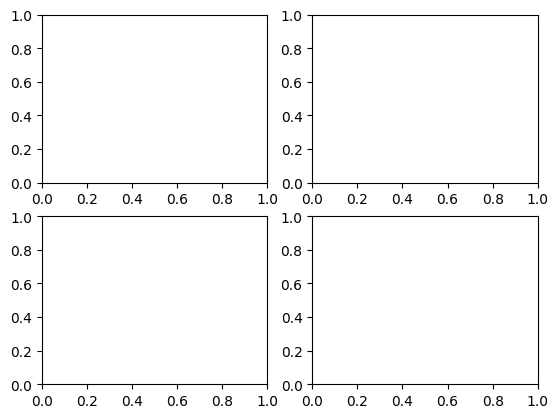

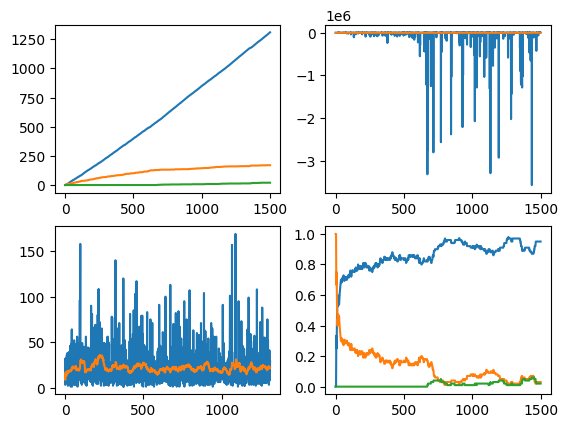

<Figure size 1500x1500 with 0 Axes>

In [171]:
NUM_ROUNDS = 1500

if __name__ == '__main__':
    train(NUM_ROUNDS, agent, reward_policy=default_policy, enable_visualization=True)

In [179]:
print("Average time to find target =",  TTWMA[len(TTWMA)-1])
print("Final training accuracy = ", win_window_50[len(win_window_50)-1])
print("highest training accuracy reached", np.max(win_window_50))

      

Average time to find target = 21.9
Final training accuracy =  0.95
highest training accuracy reached 0.98


# Save Model

In [186]:
PATH = 'C:/users/Dave/Downloads/ECE601model.pth'
torch.save(agent.model, PATH)

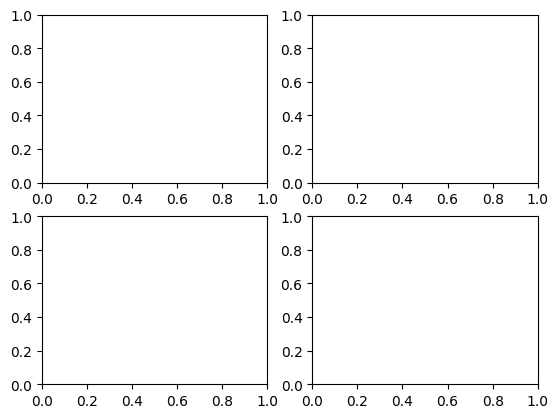

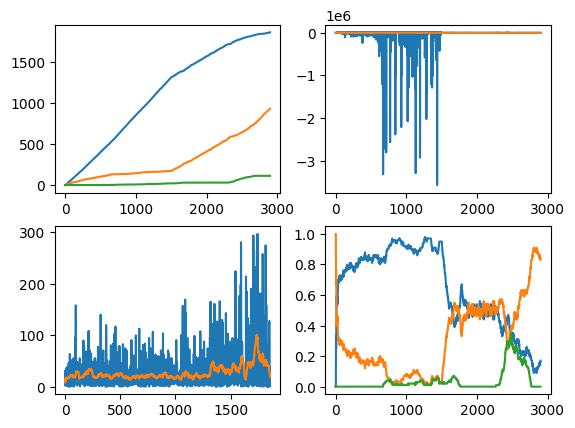

<Figure size 1500x1500 with 0 Axes>

(2, 6)
up
reward (green space):  0.0
reward (bb policy):  -0.0
reward (Total) =  -10.0
shade, val =  1 -0.2
(1, 6)
down
revisited space
reward (revisited):  -0.0
reward (green space):  0.0
reward (bb policy):  0.0
reward (Total) =  -10.0
shade, val =  1 -0.2
shade, val =  1 -0.2
(2, 6)
down
reward (green space):  0.0
reward (bb policy):  0.0
reward (Total) =  -10.0
shade, val =  1 -0.2
shade, val =  3 -0.4
(3, 6)
down
reward (green space):  3.125
reward (bb policy):  0.0
reward (Total) =  -6.875
shade, val =  1 -0.2
shade, val =  3 -0.4
shade, val =  1 -0.2
(4, 6)
down
reward (green space):  9.66167859466493
reward (bb policy):  0.0
reward (Total) =  -0.33832140533506916
shade, val =  1 -0.2
shade, val =  3 -0.4
shade, val =  1 -0.2
shade, val =  1 -0.2
(5, 6)
up
revisited space
reward (revisited):  -0.0
reward (green space):  0.17908309455587393
reward (bb policy):  0.0
reward (Total) =  -9.820916905444125
shade, val =  1 -0.2
shade, val =  3 -0.4
shade, val =  1 -0.2
shade, val =  1 

KeyboardInterrupt: 

In [190]:
FINE_TUNE_ROUNDS = 1000

reset_graphs()

if __name__ == '__main__':
    train(FINE_TUNE_ROUNDS, agent, reward_policy=policy2, enable_visualization=True)

In [175]:
PATH = 'C:/users/Dave/Downloads/ECE601model_fine_tuned.pth'
torch.save(agent.model, PATH)

In [191]:
print("Average time to find target =",  TTWMA[len(TTWMA)-1])
print("Final training accuracy = ", win_window_50[len(win_window_50)-1])
print("highest training accuracy reached", np.max(win_window_50))


Average time to find target = 20.566666666666666
Final training accuracy =  0.17
highest training accuracy reached 0.98


In [ ]:
# well that made it worse
# lets reload the good model

In [193]:
model = torch.load('C:/users/Dave/Downloads/ECE601model.pth')
agent = Agent(model)

# Evaluate the model

run 100 rounds and see metrics 

In [194]:
def evaluate_model():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    game1 = SnakeGameAI(default_policy)
    curr_game = game1
    agent.n_games = 0
    while agent.n_games < 100:
        # get old state
        state_old = agent.get_state(curr_game)

        # get move
        final_move = agent.get_action(state_old)

        # perform move and get new state
        reward, done, score = curr_game.play_step(final_move)
        state_new = agent.get_state(curr_game)

        # train short memory
        # agent.train_short_memory(state_old, final_move, reward, state_new, done)

        # remember
        agent.remember(state_old, final_move, reward, state_new, done)

        if done:
            # train long memory, plot result
            curr_game.reset()
            agent.n_games += 1
            # agent.train_long_memory()

            print('Game', agent.n_games, 'Score', score, 'Record:', record)

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            fig, ax = plt.subplots(2, 2)
            display.clear_output(wait=True)
            display.display(plt.gcf())
            ax[0, 0].plot(history_wins, label='wins')
            ax[0, 0].plot(history_OOB, label='oob')
            ax[0, 0].plot(history_timeout, label='timeout')
            ax[0, 1].plot(cumulative_reward, label='wins')
            ax[0, 1].plot(reward_window_50, label='oob')
            ax[1, 0].plot(TTW, label='wins')
            ax[1, 0].plot(TTWMA, label='oob')
            ax[1, 1].plot(win_window_50, label='wins')
            ax[1, 1].plot(oob_window_50, label='oob')
            ax[1, 1].plot(timeout_window_50, label='timeout')
            plt.figure(figsize=(15,15))
            plt.show()
    


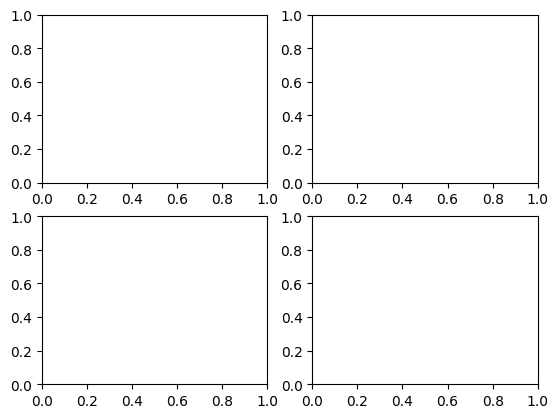

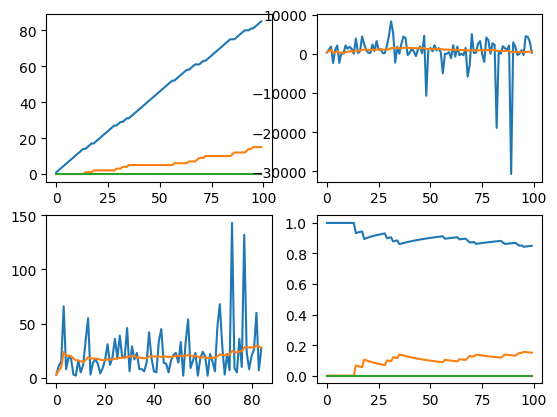

<Figure size 1500x1500 with 0 Axes>

In [198]:
evaluate_model()

In [199]:
print("Average time to find target =",  TTWMA[len(TTWMA)-1])
print("Final training accuracy = ", win_window_50[len(win_window_50)-1])


Average time to find target = 28.0
Final training accuracy =  0.85
